In [1]:
#Imports
!pip install validclust
from tensorflow import keras
from keras import layers
from validclust import dunn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt

In [2]:
#Preprocessing of image: Loading data, converting to grayscale and reshaping
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
x_test = x_test.reshape(x_test.shape[0],(x_test.shape[1]*x_test.shape[2]))
x_train = x_train.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
#Defining input size
input_img = keras.Input(shape=(32,32,3))

#Encoder layers
temp = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides =2)(input_img)
temp = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides =2)(temp)
encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides =2, name = 'encoded_imgs')(temp)

#Decoder layers
temp = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides =2)(encoded)
temp = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides =2)(temp)
temp = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same', strides =2)(temp)
decoded = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(temp)

#Building model and printing its synopsis
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

#Compiling, fitting and predicting the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, shuffle=False)
decoded_imgs = autoencoder.predict(x_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 encoded_imgs (Conv2D)       (None, 4, 4, 32)          4640      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 32)         9248      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 16)       4624      
 ranspose)                                                   

Input data images


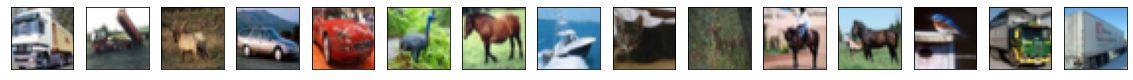

Decoder output images


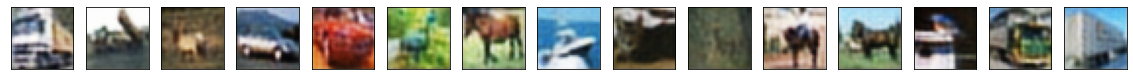

In [8]:
#Comparing original training data images and output of auto-encoder (after decoder reconstruction)

# Display original
n = 15
plt.figure(figsize=(20, 4))
print("Input data images")
for i in range(1, 16):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Display reconstruction
plt.figure(figsize=(20, 4))
print("Decoder output images")
for i in range(1, 16):
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
#Building a model to create a keras model object required to perform K-means using sklearns

encoded_imgs = keras.Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('encoded_imgs').output)
final_encoded = encoded_imgs.predict(x_train)
final_encoded = final_encoded.reshape(50000, 4*4*32)
#print(final_encoded.shape)

In [9]:
#Performing K-means clustering and calculating ASC (Average Silhouette Coefficient)
km = KMeans(n_clusters=10, n_init=12, max_iter=250, tol=1e-04).fit(final_encoded)
score = silhouette_score(final_encoded, km.labels_)
print("Silhouette score: ", score)

Silhouette score:  0.05931696
